# Classification for bank churn

Our stakeholder is not happy with the model we have so far. He does not trust AI so much and wants us to add uncertainty quantification.
The dataset can be downloaded [here](https://www.kaggle.com/competitions/playground-series-s4e1/data).

# Import libraries

In this notebook we import the package locally. However this is equivalent to !pip install bluecast==1.6.0

In [1]:
import sys

sys.path.append("/home/thomas/IdeaProjects/BlueCast")

In [2]:
from bluecast.blueprints.cast import BlueCast
from bluecast.blueprints.cast_cv import BlueCastCV
from bluecast.blueprints.cast_regression import BlueCastRegression
from bluecast.blueprints.cast_cv_regression import BlueCastCVRegression
from bluecast.conformal_prediction.effectiveness_nonconformity_measures import one_c, avg_c
from bluecast.conformal_prediction.evaluation import prediction_set_coverage
from bluecast.evaluation.shap_values import (
    shap_dependence_plots,
    shap_explanations,
    shap_waterfall_plot,
)
from bluecast.evaluation.error_analysis import ErrorAnalyserClassification, ErrorAnalyserClassificationCV

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Import the data

In [3]:
train = pd.read_csv("playground-series-s4e1/train.csv")
test = pd.read_csv("playground-series-s4e1/test.csv")
submission = pd.read_csv("playground-series-s4e1/sample_submission.csv")

In [4]:
train

id  CustomerId         Surname  CreditScore Geography  Gender  \
0            0    15674932  Okwudilichukwu          668    France    Male   
1            1    15749177   Okwudiliolisa          627    France    Male   
2            2    15694510           Hsueh          678    France    Male   
3            3    15741417             Kao          581    France    Male   
4            4    15766172       Chiemenam          716     Spain    Male   
...        ...         ...             ...          ...       ...     ...   
165029  165029    15667085            Meng          667     Spain  Female   
165030  165030    15665521       Okechukwu          792    France    Male   
165031  165031    15664752            Hsia          565    France    Male   
165032  165032    15689614          Hsiung          554     Spain  Female   
165033  165033    15732798         Ulyanov          850    France    Male   

         Age  Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       33.0       3       0.00              2        1.0             0.0   
1       33.0       1       0.00              2        1.0             1.0   
2       40.0      10       0.00              2        1.0             0.0   
3       34.0       2  148882.54              1        1.0             1.0   
4       33.0       5       0.00              2        1.0             1.0   
...      ...     ...        ...            ...        ...             ...   
165029  33.0       2       0.00              1        1.0             1.0   
165030  35.0       3       0.00              1        0.0             0.0   
165031  31.0       5       0.00              1        1.0             1.0   
165032  30.0       7  161533.00              1        0.0             1.0   
165033  31.0       1       0.00              1        1.0             0.0   

        EstimatedSalary  Exited  
0             181449.97       0  
1              49503.50       0  
2             184866.69       0  
3              84560.88       0  
4              15068.83       0  
...                 ...     ...  
165029        131834.75       0  
165030        131834.45       0  
165031        127429.56       0  
165032         71173.03       0  
165033         61581.79       1  

[165034 rows x 14 columns]

# Define constants

In [5]:
TARGET = "Exited"

# Split off some unseen data for evaluation

In [6]:
eval_size = 35000
train_eval = train.tail(eval_size)
train_eval = train_eval.reset_index(drop=True)
target_eval = train_eval.pop(TARGET)

train = train.head(len(train.index) - eval_size)
train = train.reset_index(drop=True)

In [7]:
train_eval

id  CustomerId      Surname  CreditScore Geography  Gender   Age  \
0      130034    15671973  Chukwuemeka          467     Spain    Male  27.0   
1      130035    15807481         Peng          577     Spain  Female  46.0   
2      130036    15707473      Toscani          486    France    Male  43.0   
3      130037    15603850  Nwagugheuzo          775    France  Female  41.0   
4      130038    15681412     Chibueze          619   Germany    Male  23.0   
...       ...         ...          ...          ...       ...     ...   ...   
34995  165029    15667085         Meng          667     Spain  Female  33.0   
34996  165030    15665521    Okechukwu          792    France    Male  35.0   
34997  165031    15664752         Hsia          565    France    Male  31.0   
34998  165032    15689614       Hsiung          554     Spain  Female  30.0   
34999  165033    15732798      Ulyanov          850    France    Male  31.0   

       Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0           2       0.00              2        1.0             1.0   
1           0       0.00              1        1.0             0.0   
2           2       0.00              1        1.0             1.0   
3           2   61681.39              1        1.0             0.0   
4           7  137755.68              2        0.0             0.0   
...       ...        ...            ...        ...             ...   
34995       2       0.00              1        1.0             1.0   
34996       3       0.00              1        0.0             0.0   
34997       5       0.00              1        1.0             1.0   
34998       7  161533.00              1        0.0             1.0   
34999       1       0.00              1        1.0             0.0   

       EstimatedSalary  
0              7415.96  
1            158750.53  
2            142913.98  
3            129937.82  
4            198376.49  
...                ...  
34995        131834.75  
34996        131834.45  
34997        127429.56  
34998         71173.03  
34999         61581.79  

[35000 rows x 13 columns]

# From eval dataset remove all CustomerIds that were present in train data

This will prevent leakage

In [8]:
train_customers = train["CustomerId"].unique()
train_eval_customers = train_eval["CustomerId"].unique()

train_eval_not_train_customers = [customer for customer in train_eval_customers if customer not in train_customers]

In [9]:
train_eval = train_eval.loc[train_eval["CustomerId"].isin(train_eval_not_train_customers)]
train_eval

id  CustomerId    Surname  CreditScore Geography  Gender   Age  \
10     130044    15571465        Kao          682    France  Female  44.0   
36     130070    15586521     Hsiung          671    France  Female  39.0   
52     130086    15621490   Chidimma          682    France  Female  31.0   
62     130096    15665984  Chiemenam          850    France  Female  59.0   
77     130111    15731840    Ojiofor          655   Germany  Female  43.0   
...       ...         ...        ...          ...       ...     ...   ...   
34927  164961    15673571   Ejimofor          706     Spain    Male  21.0   
34932  164966    15671312  Chiedozie          749    France  Female  35.0   
34939  164973    15772417      Mazzi          562    France    Male  33.0   
34964  164998    15692656     Hsiung          652    France    Male  39.0   
34978  165012    15815050  Trevisani          746   Germany  Female  60.0   

       Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
10          3       0.00              2        1.0             0.0   
36          4  116914.37              1        1.0             1.0   
52          7       0.00              2        0.0             1.0   
62          2       0.00              1        1.0             1.0   
77          6  106441.59              2        1.0             0.0   
...       ...        ...            ...        ...             ...   
34927       9  132678.18              1        1.0             0.0   
34932       5  117020.08              2        0.0             1.0   
34939       5       0.00              2        1.0             0.0   
34964       2       0.00              2        1.0             0.0   
34978       3  108805.42              2        1.0             0.0   

       EstimatedSalary  
10           158313.96  
36           184312.66  
52            45424.34  
62           107558.28  
77           172792.89  
...                ...  
34927         96858.18  
34932        131778.48  
34939         61531.86  
34964         93336.57  
34978         78744.37  

[2326 rows x 13 columns]

In [10]:
target_eval = target_eval.iloc[train_eval.index]

Wow, only 2.3k from 35k customers were not duplicated between train and eval dataset. This would have caused massive leakage.

# Apply learnings from EDA

In [11]:
to_drop = [] # ["id", "CustomerId", "Surname"]

train = train.drop(to_drop, axis=1)
train_eval = train_eval.drop(to_drop, axis=1)
test = test.drop(to_drop, axis=1)

# Split off a calibration dataset

In [12]:
X = train.copy()
y = X.pop(TARGET)


X_train, X_calibrate, y_train, y_calibrate = train_test_split(
     X, y, test_size=0.33, random_state=42)

X[TARGET] = y

# Creating the pipeline

In this section we create the pipeline for our base model.

In [13]:
automl_baseline = BlueCast(class_problem="binary")
automl_baseline.conf_training.out_of_fold_dataset_store_path = "/home/thomas/Schreibtisch/Data science/" # saving out of fold data
automl_baseline.conf_training.hypertuning_cv_repeats = 2  # add more robustness

2024-08-30 22:12:35,313 - root - INFO - BlueCast blueprint initialized.


As we have seen the model performance on the eval dataset we can go for a regular fit.

2024-08-30 22:12:35,327 - root - INFO - Start detecting and casting feature types.
2024-08-30 22:12:35,356 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-30 22:12:35,357 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-30 22:12:35,387 - root - INFO - Dropped the following columns as constants only: [].
2024-08-30 22:12:35,388 - root - INFO - Dropped the following columns as constants only: [].
2024-08-30 22:12:36,561 - root - WARNING - /home/thomas/IdeaProjects/BlueCast/bluecast/blueprints/cast.py:294: UserWarning: Feature selection is disabled. Update the TrainingConfig param 'enable_feature_selection'
            to enable it or make use of a custom preprocessor to do it manually during the last mile computations step.
            Feature selection is recommended for datasets with many features (>1000). For datasets with a small amount
            of features feature selection is not recommended.
            
2024-08-30 22

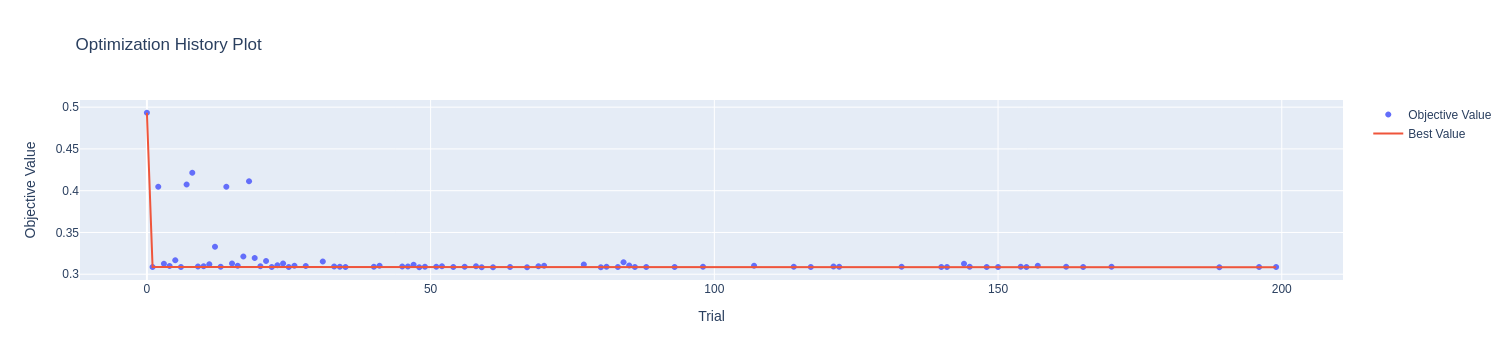

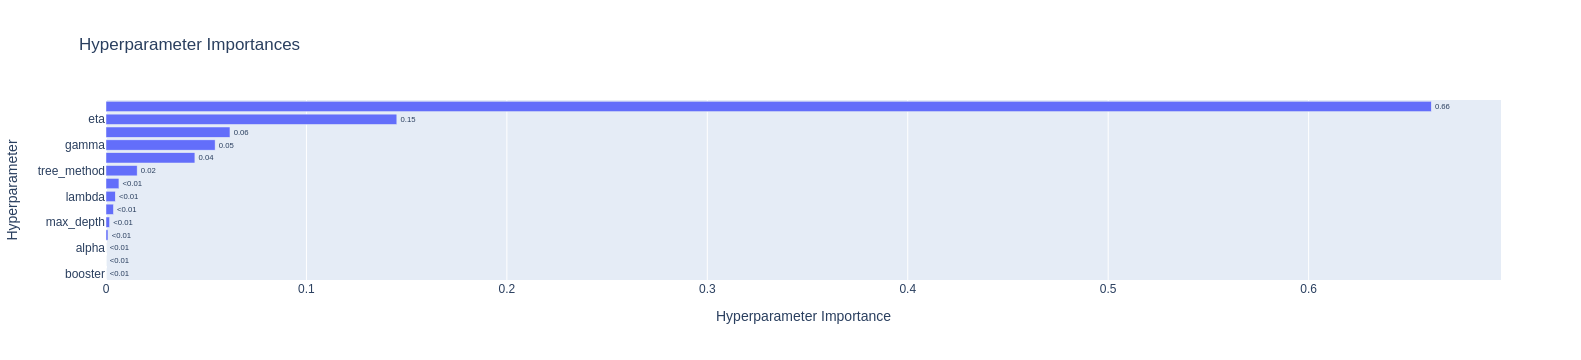

2024-08-30 23:10:18,413 - root - INFO - New best score: 0.30835985546334205 from random seed  33
2024-08-30 23:10:18,414 - root - INFO - Best params: {'validate_parameters': False, 'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'mlogloss', 'num_class': 2, 'max_depth': 6, 'alpha': 8.84138211384396e-08, 'lambda': 6.3820455379263175, 'gamma': 0.026521746278399226, 'min_child_weight': 1.575011663018506, 'subsample': 1.0, 'colsample_bytree': 0.688281786889171, 'colsample_bylevel': 0.6121551852623812, 'eta': 0.1268210214588766, 'steps': 107, 'tree_method': 'hist', 'grow_policy': 'depthwise', 'max_bin': 850}
2024-08-30 23:10:18,415 - root - INFO - Start final model training
2024-08-30 23:10:18,416 - root - INFO - Union train and test data for final model training based on TrainingConfig
             param 'use_full_data_for_final_model'


Best params: {'validate_parameters': False, 'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'mlogloss', 'num_class': 2, 'max_depth': 6, 'alpha': 8.84138211384396e-08, 'lambda': 6.3820455379263175, 'gamma': 0.026521746278399226, 'min_child_weight': 1.575011663018506, 'subsample': 1.0, 'colsample_bytree': 0.688281786889171, 'colsample_bylevel': 0.6121551852623812, 'eta': 0.1268210214588766, 'steps': 107, 'tree_method': 'hist', 'grow_policy': 'depthwise', 'max_bin': 850}
Finished hyperparameter tuning


2024-08-30 23:10:19,297 - root - INFO - Finished training


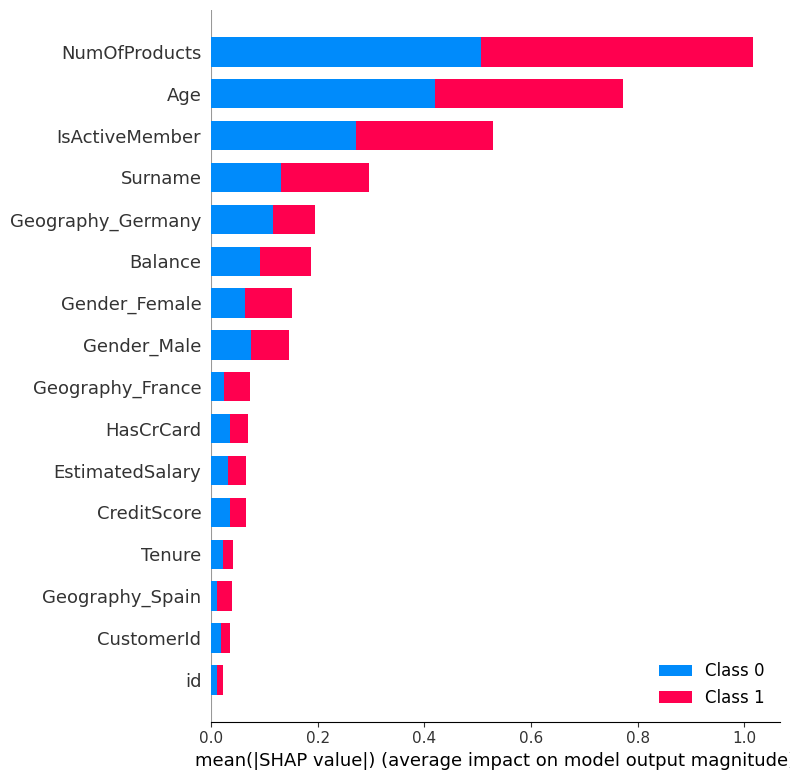

2024-08-30 23:10:35,771 - root - INFO - Plotting interactions of most important features by global SHAP values...
2024-08-30 23:10:35,776 - root - INFO - Start casting feature types.
2024-08-30 23:10:35,777 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-30 23:10:35,778 - root - INFO - Dropped the following columns as constants only: [].
2024-08-30 23:10:35,779 - root - INFO - Start filling infinite values.
2024-08-30 23:10:35,781 - root - INFO - Start date column conversion.
2024-08-30 23:10:35,782 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2024-08-30 23:10:35,783 - root - INFO - Start transforming categories with binary target encoder.
2024-08-30 23:10:35,786 - root - INFO - Start transforming categories with binary target encoder.
2024-08-30 23:10:35,794 - root - INFO - Start transforming categories with binary target encoder.
2024-08-30 23:10:35,797 - root - INFO - Predicting...
2024-08-30 23:10:35

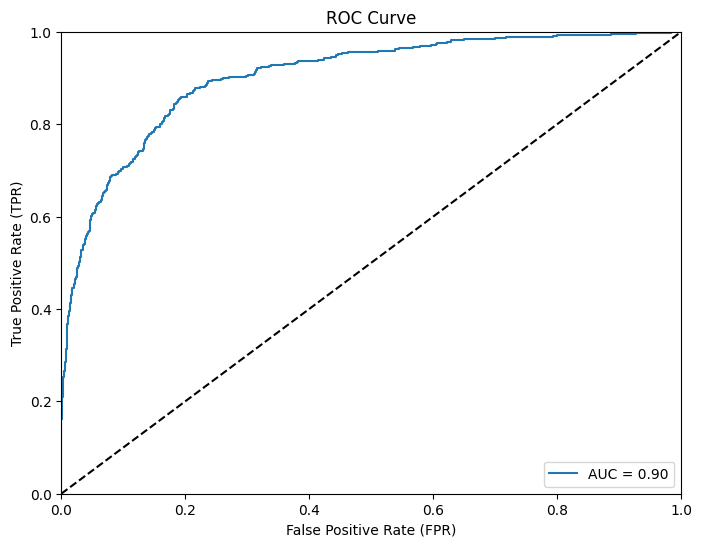

2024-08-30 23:10:35,933 - root - WARNING - /home/thomas/IdeaProjects/BlueCast/bluecast/evaluation/eval_metrics.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


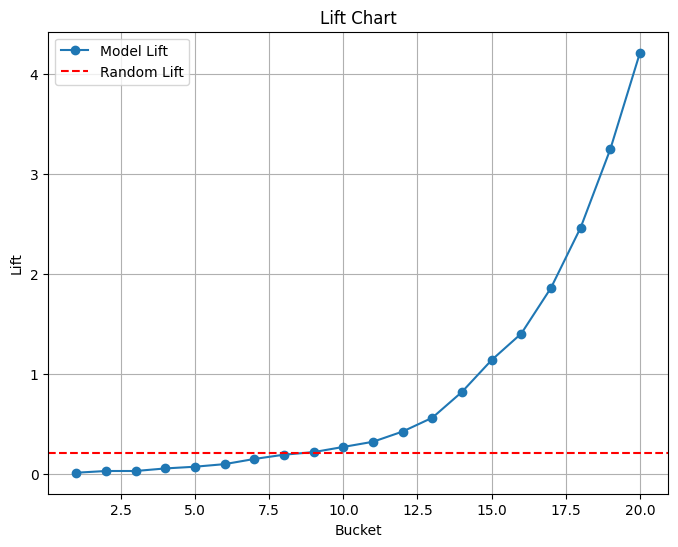

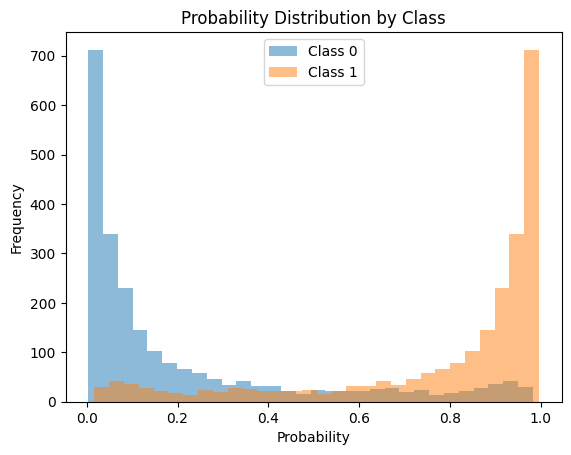

2024-08-30 23:10:36,200 - root - INFO - Start saving out of fold data.


{'matthews': 0.5900014909530312,
 'accuracy': 0.8736027515047291,
 'recall': 0.8736027515047291,
 'f1_score_macro': 0.7891642711004065,
 'f1_score_micro': 0.8736027515047291,
 'f1_score_weighted': 0.8663750011440331,
 'log_loss': 0.29927377377451897,
 'balanced_logloss': 0.5051076412200928,
 'roc_auc': 0.9029000489084522,
 'classfication_report': '              precision    recall  f1-score   support\n\n           0       0.89      0.95      0.92      1836\n           1       0.77      0.57      0.66       490\n\n    accuracy                           0.87      2326\n   macro avg       0.83      0.76      0.79      2326\nweighted avg       0.87      0.87      0.87      2326\n',
 'confusion_matrix': array([[1752,   84],
        [ 210,  280]])}

In [14]:
automl_baseline.fit_eval(
    df=X,
    df_eval=train_eval,
    target_eval=target_eval,
    target_col=TARGET,
)

# Error analysis

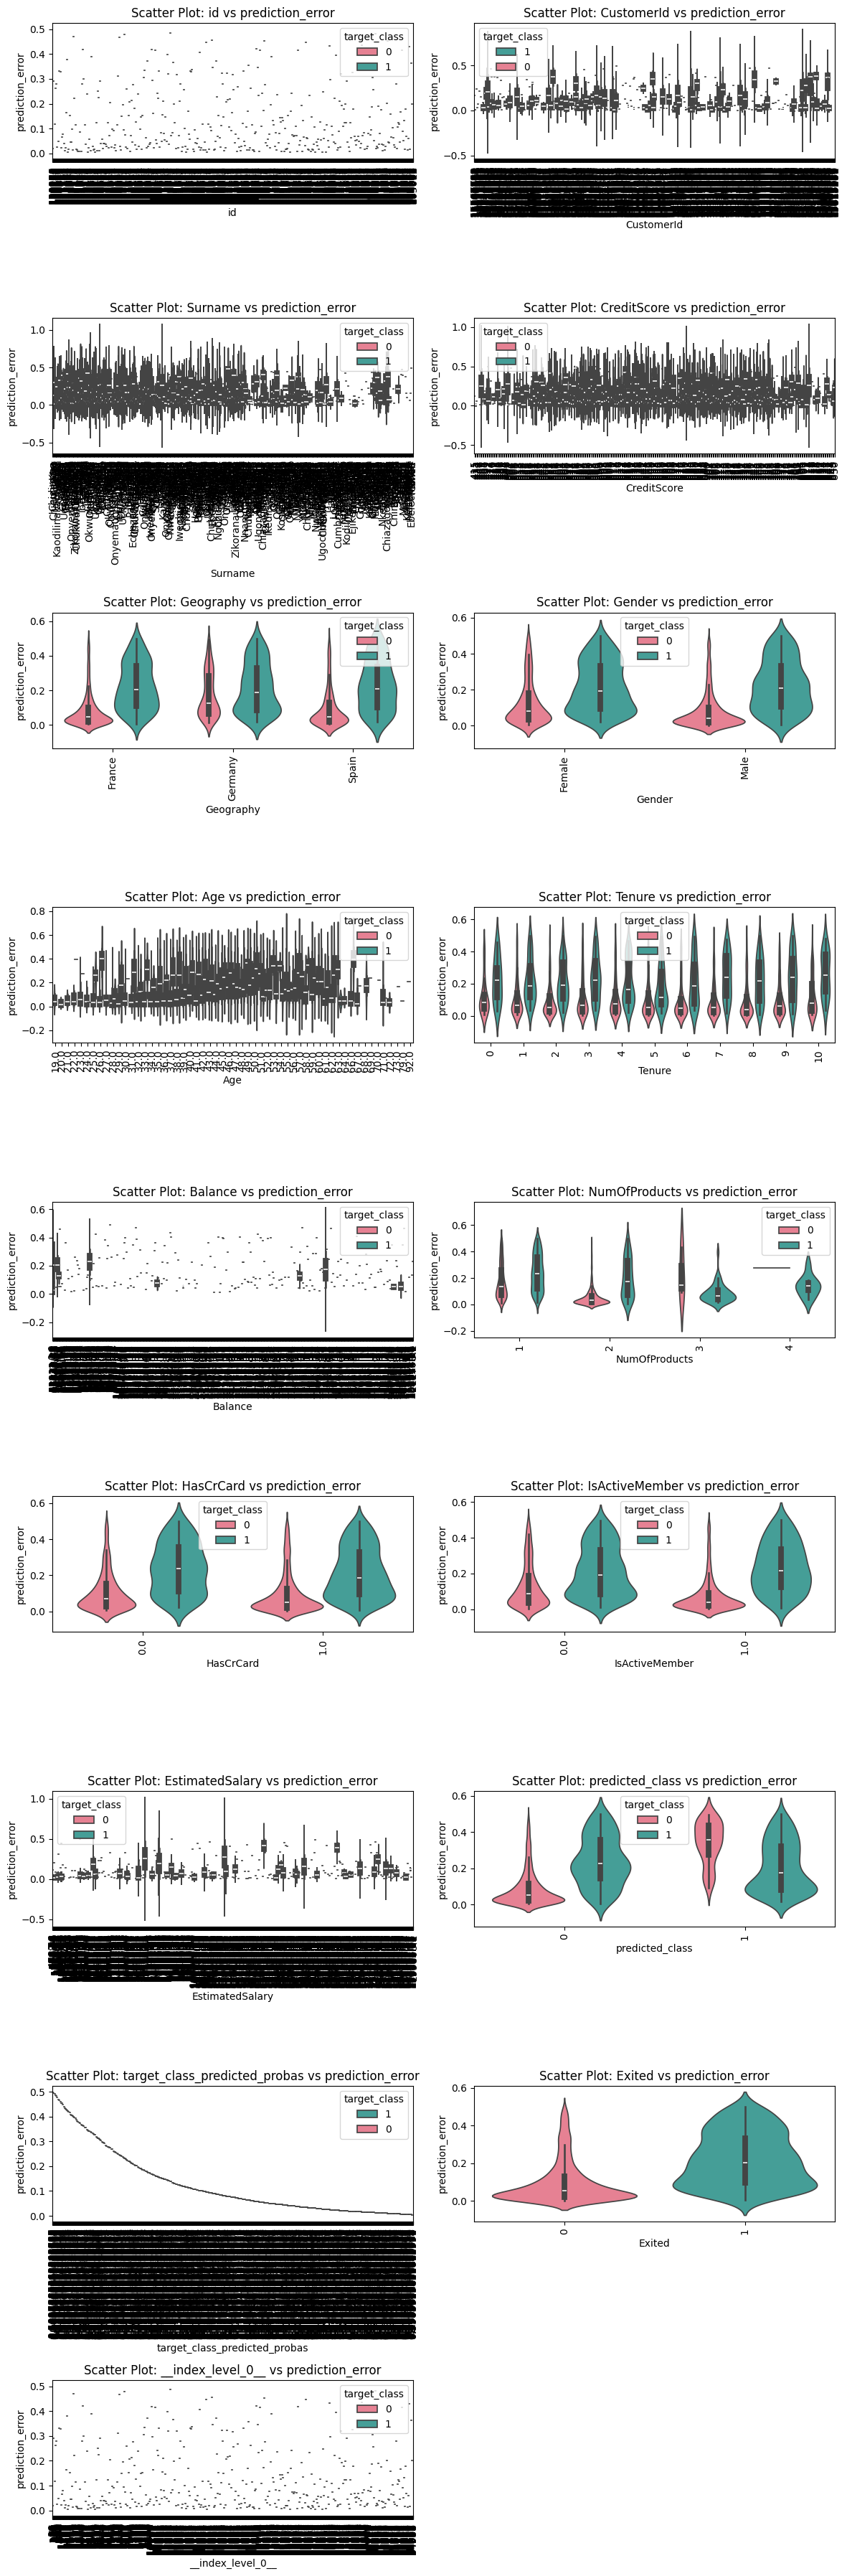

In [15]:
error_analyser = ErrorAnalyserClassification(automl_baseline)
analysis_result = error_analyser.analyse_segment_errors()

In [16]:
analysis_result

shape: (1_048, 4)
┌────────────────┬──────────────┬──────────────────┬───────────────────────────────┐
│ column_subset  ┆ target_class ┆ prediction_error ┆ column_name                   │
│ ---            ┆ ---          ┆ ---              ┆ ---                           │
│ str            ┆ i32          ┆ f64              ┆ str                           │
╞════════════════╪══════════════╪══════════════════╪═══════════════════════════════╡
│ (-inf, 1]      ┆ 1            ┆ 0.499431         ┆ target_class_predicted_probas │
│ Zetticci       ┆ 1            ┆ 0.499271         ┆ Surname                       │
│ Ejimofor       ┆ 1            ┆ 0.498212         ┆ Surname                       │
│ Oster          ┆ 1            ┆ 0.493295         ┆ Surname                       │
│ Aksenova       ┆ 0            ┆ 0.490377         ┆ Surname                       │
│ …              ┆ …            ┆ …                ┆ …                             │
│ (-inf, 1]      ┆ 0            ┆ 0.006292         ┆ Tenure                        │
│ (2209.75, inf] ┆ 1            ┆ 0.00585          ┆ target_class_predicted_probas │
│ (-inf, 1]      ┆ 1            ┆ 0.00585          ┆ prediction                    │
│ Pendergrass    ┆ 0            ┆ 0.004335         ┆ Surname                       │
│ Onuora         ┆ 0            ┆ 0.003933         ┆ Surname                       │
└────────────────┴──────────────┴──────────────────┴───────────────────────────────┘

Now it is time to calibrate our model.

In [17]:
automl_baseline.calibrate(X_calibrate, y_calibrate)

2024-08-30 23:12:47,577 - root - INFO - Start casting feature types.
2024-08-30 23:12:47,583 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-30 23:12:47,584 - root - INFO - Dropped the following columns as constants only: [].
2024-08-30 23:12:47,588 - root - INFO - Start filling infinite values.
2024-08-30 23:12:47,599 - root - INFO - Start date column conversion.
2024-08-30 23:12:47,599 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2024-08-30 23:12:47,601 - root - INFO - Start transforming categories with binary target encoder.
2024-08-30 23:12:47,607 - root - INFO - Start transforming categories with binary target encoder.
2024-08-30 23:12:47,621 - root - INFO - Start transforming categories with binary target encoder.
2024-08-30 23:12:47,627 - root - INFO - Start predicting on new data using Xgboost model.
2024-08-30 23:12:47,654 - root - INFO - Finished predicting


This time we use our eval dataset to check our prediction intervals / prediction sets.

In [18]:
pred_sets = automl_baseline.predict_sets(train_eval, alpha=0.05)  # 95% confidence

2024-08-30 23:12:47,772 - root - INFO - Start casting feature types.
2024-08-30 23:12:47,775 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-30 23:12:47,775 - root - INFO - Dropped the following columns as constants only: [].
2024-08-30 23:12:47,776 - root - INFO - Start filling infinite values.
2024-08-30 23:12:47,778 - root - INFO - Start date column conversion.
2024-08-30 23:12:47,778 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2024-08-30 23:12:47,779 - root - INFO - Start transforming categories with binary target encoder.
2024-08-30 23:12:47,781 - root - INFO - Start transforming categories with binary target encoder.
2024-08-30 23:12:47,786 - root - INFO - Start transforming categories with binary target encoder.
2024-08-30 23:12:47,788 - root - INFO - Start predicting on new data using Xgboost model.
2024-08-30 23:12:47,793 - root - INFO - Finished predicting


In [19]:
# return the percentage of sets with one label only (higher is better)
one_c(pred_sets)

0.8112639724849527

82% of our sets have one class only. This sounds good first hand, but could also mean it is just certain for non-churn cases.

In [20]:
# return the mean number of labels per prediction set (lower is better)
avg_c(pred_sets)

1.1887360275150474

The average prediction set size is 1.18. Now we can evaluate on our eval dataset.

In [21]:
evaluation = pd.DataFrame(
    {
        "y_eval": target_eval.values.reshape(-1),
        "pred_sets": pred_sets.values.reshape(-1),
        "len_pred_sets": np.asarray([len(pred_set[0]) for pred_set in pred_sets.values])
    }
)
evaluation

y_eval pred_sets  len_pred_sets
0          0       {0}              1
1          1       {0}              1
2          0       {0}              1
3          0    {0, 1}              2
4          0    {0, 1}              2
...      ...       ...            ...
2321       0       {0}              1
2322       0       {0}              1
2323       0       {0}              1
2324       0       {0}              1
2325       1       {1}              1

[2326 rows x 3 columns]

In [22]:
prediction_set_coverage(target_eval, pred_sets)

0.943250214961307

We achieved almost the desired 95% coverage.

In [23]:
prediction_set_coverage(
    evaluation.loc[evaluation["y_eval"] == 0]["y_eval"],
    evaluation.loc[evaluation["y_eval"] == 0]["pred_sets"]
)

0.9907407407407407

In [24]:
prediction_set_coverage(
    evaluation.loc[evaluation["y_eval"] == 1]["y_eval"],
    evaluation.loc[evaluation["y_eval"] == 1]["pred_sets"]
)

0.7653061224489796

So for non churners the correct class has been in 99% of the prediction sets. For churners we covered 76%, which is not bad for an MVP.

# Predict on the new data

In [25]:
pred_sets_test = automl_baseline.predict_sets(test,  alpha=0.05)
pred_sets_test

2024-08-30 23:12:48,029 - root - INFO - Start casting feature types.
2024-08-30 23:12:48,034 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-30 23:12:48,035 - root - INFO - Dropped the following columns as constants only: [].
2024-08-30 23:12:48,041 - root - INFO - Start filling infinite values.
2024-08-30 23:12:48,063 - root - INFO - Start date column conversion.
2024-08-30 23:12:48,063 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2024-08-30 23:12:48,067 - root - INFO - Start transforming categories with binary target encoder.
2024-08-30 23:12:48,079 - root - INFO - Start transforming categories with binary target encoder.
2024-08-30 23:12:48,104 - root - INFO - Start transforming categories with binary target encoder.
2024-08-30 23:12:48,116 - root - INFO - Start predicting on new data using Xgboost model.
2024-08-30 23:12:48,173 - root - INFO - Finished predicting


prediction_set
0                 {0}
1                 {1}
2                 {0}
3                 {0}
4              {0, 1}
...               ...
110018            {0}
110019            {0}
110020            {0}
110021            {0}
110022            {0}

[110023 rows x 1 columns]

In [26]:
pvalues_test = automl_baseline.predict_p_values(test)
pvalues_test

2024-08-30 23:12:53,205 - root - INFO - Start casting feature types.
2024-08-30 23:12:53,207 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-30 23:12:53,207 - root - INFO - Dropped the following columns as constants only: [].
2024-08-30 23:12:53,210 - root - INFO - Start filling infinite values.
2024-08-30 23:12:53,230 - root - INFO - Start date column conversion.
2024-08-30 23:12:53,230 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2024-08-30 23:12:53,234 - root - INFO - Start transforming categories with binary target encoder.
2024-08-30 23:12:53,247 - root - INFO - Start transforming categories with binary target encoder.
2024-08-30 23:12:53,272 - root - INFO - Start transforming categories with binary target encoder.
2024-08-30 23:12:53,284 - root - INFO - Start predicting on new data using Xgboost model.
2024-08-30 23:12:53,341 - root - INFO - Finished predicting


array([[0.74790856, 0.00195745],
       [0.01906182, 0.41989607],
       [0.73656002, 0.00216718],
       ...,
       [0.76247291, 0.00177103],
       [0.31729313, 0.03413884],
       [0.31985645, 0.03357957]])

# Get SHAP values for the new data

2024-08-30 23:12:58,270 - root - INFO - Start casting feature types.
2024-08-30 23:12:58,272 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-30 23:12:58,272 - root - INFO - Dropped the following columns as constants only: [].
2024-08-30 23:12:58,275 - root - INFO - Start filling infinite values.
2024-08-30 23:12:58,295 - root - INFO - Start date column conversion.
2024-08-30 23:12:58,295 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2024-08-30 23:12:58,299 - root - INFO - Start transforming categories with binary target encoder.
2024-08-30 23:12:58,312 - root - INFO - Start transforming categories with binary target encoder.
2024-08-30 23:12:58,336 - root - INFO - Start transforming categories with binary target encoder.
2024-08-30 23:12:58,348 - root - INFO - Predicting...
2024-08-30 23:12:58,348 - root - INFO - Start predicting on new data using Xgboost model.
2024-08-30 23:12:58,491 - root - INFO - Fin

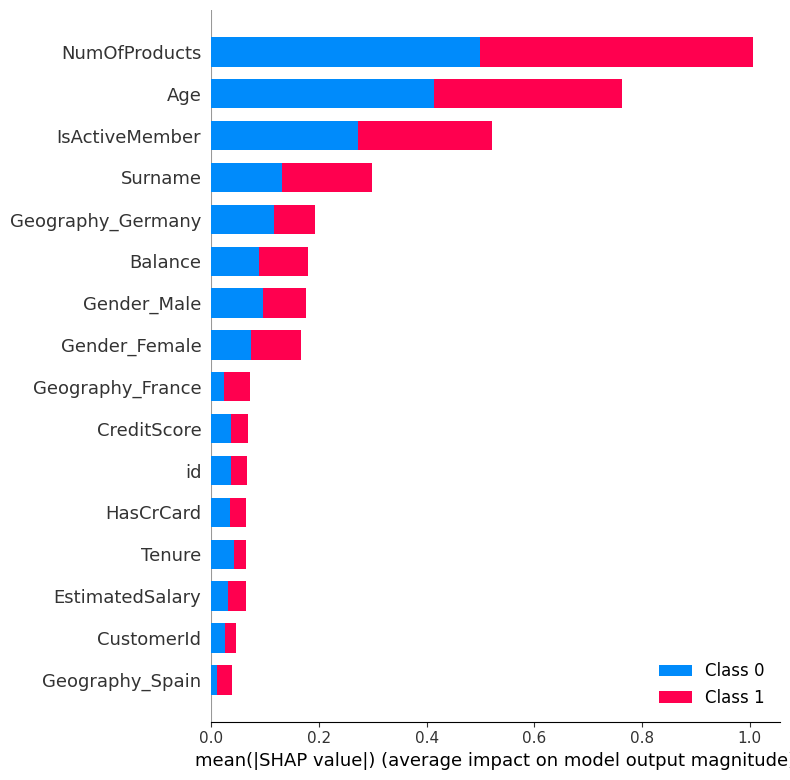

In [27]:
y_probs, y_classes = automl_baseline.predict(test, save_shap_values=True)

In [28]:
automl_baseline.conf_training.shap_waterfall_indices

[]

Here we could pass a list of indices and BlueCast will show the Shaples values as waterfall chart for these rows of interest.

In [29]:
shap_waterfall_plot(
    automl_baseline.explainer, 
    automl_baseline.conf_training.shap_waterfall_indices, 
    automl_baseline.class_problem
)

So for this customer NumOfProducts has been the main contributor of the final prediction.

In [30]:
 shap_dependence_plots(
    automl_baseline.shap_values,
    automl_baseline.transform_new_data(test),
    automl_baseline.conf_training.show_dependence_plots_of_top_n_features,
 )

2024-08-30 23:14:04,748 - root - INFO - Start casting feature types.
2024-08-30 23:14:04,754 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-30 23:14:04,755 - root - INFO - Dropped the following columns as constants only: [].
2024-08-30 23:14:04,761 - root - INFO - Start filling infinite values.
2024-08-30 23:14:04,793 - root - INFO - Start date column conversion.
2024-08-30 23:14:04,793 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2024-08-30 23:14:04,798 - root - INFO - Start transforming categories with binary target encoder.
2024-08-30 23:14:04,819 - root - INFO - Start transforming categories with binary target encoder.
2024-08-30 23:14:04,858 - root - INFO - Start transforming categories with binary target encoder.
2024-08-30 23:14:04,878 - root - INFO - Plotting interactions of most important features by global SHAP values...


In [31]:
submission[TARGET] = pvalues_test[:, 1]
submission[["id", TARGET]].to_csv("automl_default_conformal_prediction_bluecast_pipeline.csv", index=False)
submission

id    Exited
0       165034  0.001957
1       165035  0.419896
2       165036  0.002167
3       165037  0.029385
4       165038  0.100273
...        ...       ...
110018  275052  0.002004
110019  275053  0.020600
110020  275054  0.001771
110021  275055  0.034139
110022  275056  0.033580

[110023 rows x 2 columns]

# Summary

We can show our stakeholder that we are able to predict not only point estimates, but even prediction sets! This will make our predictions more trustworthy.